## Autoencoders and PCA

**Principal Component Analysis** is a specific kind of dimensionality reduction technique. Review [this example](https://scikit-learn.org/stable/auto_examples/decomposition/plot_pca_iris.html) to get acquainted with PCA as implemented by `scikit-learn`.


**Linear Autoencoders** are strongly related to PCA. See the notes [here](https://medium.com/analytics-vidhya/journey-from-principle-component-analysis-to-autoencoders-e60d066f191a) and [here](https://www.cs.toronto.edu/~urtasun/courses/CSC411/14_pca.pdf). In some way, an autoencoder can be viewed as a generalization of PCA when using other activation functions and deeper architectures.


In this lab **you will have to do two things**:

- Explain in your own terms (and math) why PCAs are so strongly related to a Linear Autoencoder. Include a reasoning of why _linear_ and not other kind of autoencoder.

- Build an example with actual data showing this equivalence. You may use the dataset of **eigenfaces** referred two in the noted linked above, or another dataset of your choice.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import decomposition
from sklearn import datasets
%matplotlib inline

from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input
from tensorflow.keras.backend import clear_session
from tensorflow.keras.regularizers import l1
from tensorflow.keras.losses import mse
import tensorflow as tf
from tensorflow.keras import backend as K

tf.__version__

'2.2.0'

In [2]:
faces = datasets.fetch_olivetti_faces()
print(faces.data.shape)

X=faces.data
y=faces.target
print("dimension de las imagenes y las clases", X.shape, y.shape)

(400, 4096)
dimension de las imagenes y las clases (400, 4096) (400,)


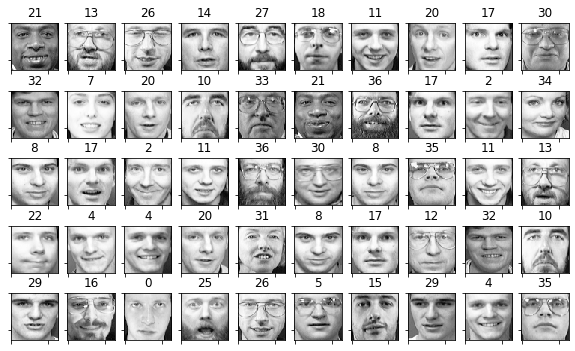

In [3]:
perm = np.random.permutation(list(range(X.shape[0])))[0:50]
random_imgs   = X[perm]
random_labels = y[perm] 
fig = plt.figure(figsize=(10,6))
for i in range(random_imgs.shape[0]):
    ax=fig.add_subplot(5,10,i+1)
    plt.imshow(random_imgs[i].reshape(64,64), interpolation="nearest", cmap = plt.cm.Greys_r)
    ax.set_title(int(random_labels[i]))
    ax.set_xticklabels([])
    ax.set_yticklabels([])

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)

In [136]:
mu = X_train.mean(axis=0)
U,s,V = np.linalg.svd(X_train - mu, full_matrices=False)
Zpca = np.dot(X_train - mu, V.transpose())

Rpca = np.dot(Zpca[:,:2], V[:2,:]) + mu    # reconstruction
err = np.sum((X_train-Rpca)**2)/Rpca.shape[0]/Rpca.shape[1]
print('PCA reconstruction error with 2 PCs: ' + str(round(err,3)));

(320, 320)
PCA reconstruction error with 2 PCs: 0.012


In [127]:
#Autoencoders
def get_model(input_dim, code_size):
    
    # architecture 1
    inputs = Input(shape=input_dim)
    layers = Dense(512, activation='linear')(inputs)
    layers = Dense(128, activation='linear')(layers)
    encoder = Dense(2, activation='linear', name="encoder")(layers)
    layers = Dense(128, activation='linear')(encoder)
    layers = Dense(512, activation='linear')(layers)
    outputs = Dense(input_dim, activation='linear')(layers)
    
    # architecture 2
    #inputs = Input(shape=input_dim)
    #encoder = Dense(code_size, activation='linear', name="encoder")(inputs)
    #outputs = Dense(input_dim, activation='linear')(encoder)

    avg_latent_activations = tf.reduce_mean(encoder, axis=0)
    loss = tf.reduce_mean( (inputs-outputs)**2)
    
    model = Model([inputs], [outputs])   
    model.add_loss(loss)     
    model.compile(optimizer='adam')
    return model, encoder, avg_latent_activations

In [128]:
model, encoder, avg_latent_activations = get_model(input_dim=X.shape[1], code_size=256)

In [129]:
model.fit(X_train, epochs=100, batch_size=32)

Epoch 1/100
10/10 [==============================] - 0s 2ms/step - loss: 1.6239
Epoch 2/100
10/10 [==============================] - 0s 2ms/step - loss: 0.4303
Epoch 3/100
10/10 [==============================] - 0s 2ms/step - loss: 0.1850
Epoch 4/100
10/10 [==============================] - 0s 1ms/step - loss: 0.0558
Epoch 5/100
10/10 [==============================] - 0s 1ms/step - loss: 0.0304
Epoch 6/100
10/10 [==============================] - 0s 1ms/step - loss: 0.0204
Epoch 7/100
10/10 [==============================] - 0s 1ms/step - loss: 0.0171
Epoch 8/100
10/10 [==============================] - 0s 1ms/step - loss: 0.0159
Epoch 9/100
10/10 [==============================] - 0s 1ms/step - loss: 0.0155
Epoch 10/100
10/10 [==============================] - 0s 1ms/step - loss: 0.0153
Epoch 11/100
10/10 [==============================] - 0s 1ms/step - loss: 0.0153
Epoch 12/100
10/10 [==============================] - 0s 1ms/step - loss: 0.0152
Epoch 13/100
10/10 [=================

In [137]:
encoder = Model(model.input, model.get_layer('encoder').output)
Zenc = encoder.predict(X_train)  # bottleneck representation
Renc = model.predict(X_train)        # reconstruction

print("error autoencoders: "+str(np.mean(mse(X_train, Renc))))

error autoencoders: 0.012296871


In [200]:
# testing PCA from Sckit learn
pca = decomposition.PCA(n_components=56, svd_solver='full')
pca.fit(X_train)

PCA(n_components=56, svd_solver='full')

In [178]:
#Autoencoders
def get_model(input_dim, code_size):
    
    inputs = Input(shape=input_dim)
    encoder = Dense(code_size, activation='linear', name="encoder")(inputs)
    outputs = Dense(input_dim, activation='linear')(encoder)

    avg_latent_activations = tf.reduce_mean(encoder, axis=0)
    loss = tf.reduce_mean( (inputs-outputs)**2)
    
    model = Model([inputs], [outputs])   
    model.add_loss(loss)     
    model.compile(optimizer='adam')
    return model, encoder, avg_latent_activations

In [190]:
model, encoder, avg_latent_activations = get_model(input_dim=X.shape[1], code_size=56)

In [204]:
model.fit(X_train, epochs=800, batch_size=64)

Epoch 1/800
5/5 [==============================] - 0s 2ms/step - loss: 0.0023
Epoch 2/800
5/5 [==============================] - 0s 1ms/step - loss: 0.0023
Epoch 3/800
5/5 [==============================] - 0s 1ms/step - loss: 0.0023
Epoch 4/800
5/5 [==============================] - 0s 1ms/step - loss: 0.0023
Epoch 5/800
5/5 [==============================] - 0s 1ms/step - loss: 0.0023
Epoch 6/800
5/5 [==============================] - 0s 1ms/step - loss: 0.0023
Epoch 7/800
5/5 [==============================] - 0s 1ms/step - loss: 0.0023
Epoch 8/800
5/5 [==============================] - 0s 1ms/step - loss: 0.0023
Epoch 9/800
5/5 [==============================] - 0s 1ms/step - loss: 0.0023
Epoch 10/800
5/5 [==============================] - 0s 1ms/step - loss: 0.0024
Epoch 11/800
5/5 [==============================] - 0s 1ms/step - loss: 0.0025
Epoch 12/800
5/5 [==============================] - 0s 1ms/step - loss: 0.0025
Epoch 13/800
5/5 [==============================] - 0s 1ms/st

5/5 [==============================] - 0s 1ms/step - loss: 0.0031
Epoch 105/800
5/5 [==============================] - 0s 1ms/step - loss: 0.0028
Epoch 106/800
5/5 [==============================] - 0s 1ms/step - loss: 0.0025
Epoch 107/800
5/5 [==============================] - 0s 1ms/step - loss: 0.0025
Epoch 108/800
5/5 [==============================] - 0s 1ms/step - loss: 0.0024
Epoch 109/800
5/5 [==============================] - 0s 1ms/step - loss: 0.0024
Epoch 110/800
5/5 [==============================] - 0s 1ms/step - loss: 0.0023
Epoch 111/800
5/5 [==============================] - 0s 992us/step - loss: 0.0023
Epoch 112/800
5/5 [==============================] - 0s 1ms/step - loss: 0.0023
Epoch 113/800
5/5 [==============================] - 0s 1ms/step - loss: 0.0023
Epoch 114/800
5/5 [==============================] - 0s 1ms/step - loss: 0.0023
Epoch 115/800
5/5 [==============================] - 0s 1ms/step - loss: 0.0023
Epoch 116/800
5/5 [==============================] -

5/5 [==============================] - 0s 1ms/step - loss: 0.0028
Epoch 207/800
5/5 [==============================] - 0s 1ms/step - loss: 0.0028
Epoch 208/800
5/5 [==============================] - 0s 1ms/step - loss: 0.0028
Epoch 209/800
5/5 [==============================] - 0s 948us/step - loss: 0.0028
Epoch 210/800
5/5 [==============================] - 0s 979us/step - loss: 0.0027
Epoch 211/800
5/5 [==============================] - 0s 1ms/step - loss: 0.0027
Epoch 212/800
5/5 [==============================] - 0s 1ms/step - loss: 0.0027
Epoch 213/800
5/5 [==============================] - 0s 1ms/step - loss: 0.0027
Epoch 214/800
5/5 [==============================] - 0s 1ms/step - loss: 0.0027
Epoch 215/800
5/5 [==============================] - 0s 1ms/step - loss: 0.0027
Epoch 216/800
5/5 [==============================] - 0s 1ms/step - loss: 0.0027
Epoch 217/800
5/5 [==============================] - 0s 993us/step - loss: 0.0026
Epoch 218/800
5/5 [=============================

5/5 [==============================] - 0s 1ms/step - loss: 0.0023
Epoch 309/800
5/5 [==============================] - 0s 1ms/step - loss: 0.0023
Epoch 310/800
5/5 [==============================] - 0s 1ms/step - loss: 0.0023
Epoch 311/800
5/5 [==============================] - 0s 1ms/step - loss: 0.0023
Epoch 312/800
5/5 [==============================] - 0s 1ms/step - loss: 0.0023
Epoch 313/800
5/5 [==============================] - 0s 1ms/step - loss: 0.0023
Epoch 314/800
5/5 [==============================] - 0s 1ms/step - loss: 0.0023
Epoch 315/800
5/5 [==============================] - 0s 1ms/step - loss: 0.0023
Epoch 316/800
5/5 [==============================] - 0s 1ms/step - loss: 0.0023
Epoch 317/800
5/5 [==============================] - 0s 1ms/step - loss: 0.0023
Epoch 318/800
5/5 [==============================] - 0s 1ms/step - loss: 0.0023
Epoch 319/800
5/5 [==============================] - 0s 1ms/step - loss: 0.0023
Epoch 320/800
5/5 [==============================] - 0

5/5 [==============================] - 0s 1ms/step - loss: 0.0022
Epoch 411/800
5/5 [==============================] - 0s 1ms/step - loss: 0.0022
Epoch 412/800
5/5 [==============================] - 0s 1ms/step - loss: 0.0022
Epoch 413/800
5/5 [==============================] - 0s 1ms/step - loss: 0.0022
Epoch 414/800
5/5 [==============================] - 0s 1ms/step - loss: 0.0022
Epoch 415/800
5/5 [==============================] - 0s 1ms/step - loss: 0.0022
Epoch 416/800
5/5 [==============================] - 0s 1ms/step - loss: 0.0022
Epoch 417/800
5/5 [==============================] - 0s 985us/step - loss: 0.0022
Epoch 418/800
5/5 [==============================] - 0s 1ms/step - loss: 0.0022
Epoch 419/800
5/5 [==============================] - 0s 1ms/step - loss: 0.0022
Epoch 420/800
5/5 [==============================] - 0s 1ms/step - loss: 0.0022
Epoch 421/800
5/5 [==============================] - 0s 1ms/step - loss: 0.0022
Epoch 422/800
5/5 [==============================] -

5/5 [==============================] - 0s 1ms/step - loss: 0.0022
Epoch 513/800
5/5 [==============================] - 0s 1ms/step - loss: 0.0022
Epoch 514/800
5/5 [==============================] - 0s 1ms/step - loss: 0.0022
Epoch 515/800
5/5 [==============================] - 0s 1ms/step - loss: 0.0022
Epoch 516/800
5/5 [==============================] - 0s 1ms/step - loss: 0.0022
Epoch 517/800
5/5 [==============================] - 0s 1ms/step - loss: 0.0022
Epoch 518/800
5/5 [==============================] - 0s 1ms/step - loss: 0.0022
Epoch 519/800
5/5 [==============================] - 0s 984us/step - loss: 0.0022
Epoch 520/800
5/5 [==============================] - 0s 982us/step - loss: 0.0022
Epoch 521/800
5/5 [==============================] - 0s 1ms/step - loss: 0.0022
Epoch 522/800
5/5 [==============================] - 0s 1ms/step - loss: 0.0022
Epoch 523/800
5/5 [==============================] - 0s 1ms/step - loss: 0.0022
Epoch 524/800
5/5 [==============================]

5/5 [==============================] - 0s 1ms/step - loss: 0.0022
Epoch 615/800
5/5 [==============================] - 0s 1ms/step - loss: 0.0023
Epoch 616/800
5/5 [==============================] - 0s 1ms/step - loss: 0.0022
Epoch 617/800
5/5 [==============================] - 0s 1ms/step - loss: 0.0022
Epoch 618/800
5/5 [==============================] - 0s 1ms/step - loss: 0.0022
Epoch 619/800
5/5 [==============================] - 0s 1ms/step - loss: 0.0022
Epoch 620/800
5/5 [==============================] - 0s 1ms/step - loss: 0.0022
Epoch 621/800
5/5 [==============================] - 0s 1ms/step - loss: 0.0022
Epoch 622/800
5/5 [==============================] - 0s 1ms/step - loss: 0.0022
Epoch 623/800
5/5 [==============================] - 0s 978us/step - loss: 0.0022
Epoch 624/800
5/5 [==============================] - 0s 1ms/step - loss: 0.0022
Epoch 625/800
5/5 [==============================] - 0s 1ms/step - loss: 0.0022
Epoch 626/800
5/5 [==============================] -

5/5 [==============================] - 0s 1ms/step - loss: 0.0022
Epoch 717/800
5/5 [==============================] - 0s 1ms/step - loss: 0.0022
Epoch 718/800
5/5 [==============================] - 0s 1ms/step - loss: 0.0022
Epoch 719/800
5/5 [==============================] - 0s 1ms/step - loss: 0.0022
Epoch 720/800
5/5 [==============================] - 0s 1ms/step - loss: 0.0022
Epoch 721/800
5/5 [==============================] - 0s 1ms/step - loss: 0.0022
Epoch 722/800
5/5 [==============================] - 0s 1ms/step - loss: 0.0022
Epoch 723/800
5/5 [==============================] - 0s 1ms/step - loss: 0.0022
Epoch 724/800
5/5 [==============================] - 0s 1ms/step - loss: 0.0022
Epoch 725/800
5/5 [==============================] - 0s 997us/step - loss: 0.0022
Epoch 726/800
5/5 [==============================] - 0s 1ms/step - loss: 0.0022
Epoch 727/800
5/5 [==============================] - 0s 1ms/step - loss: 0.0022
Epoch 728/800
5/5 [==============================] -

error autoencoders: 0.003681515
error PCA: 0.003608425


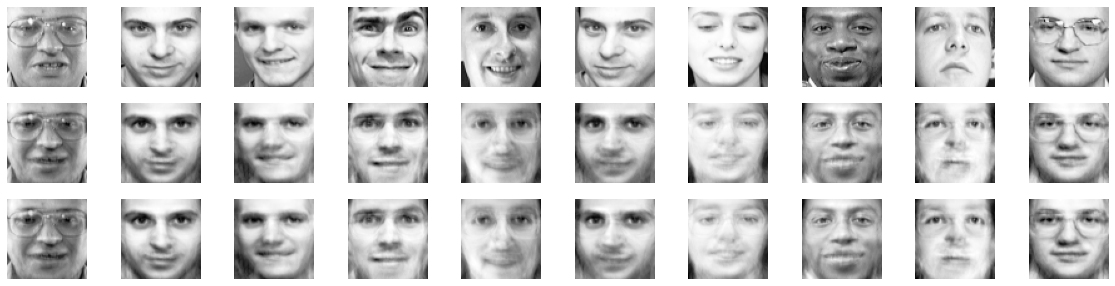

In [205]:
X_sample = np.random.permutation(X_test)[:10]
#reconstruct from autoencoders
X_pred   = model.predict(X_sample)
#print(X_pred.shape)

#reconstruct from pca
X_samplePCA = pca.transform(X_sample)
X_predPCA = pca.inverse_transform(X_samplePCA)

print("error autoencoders: "+str(np.mean(mse(X_sample, X_pred))))

print("error PCA: "+str(np.mean(mse(X_sample, X_predPCA))))

plt.figure(figsize=(20,5))
for i in range(len(X_sample)):
    plt.subplot(3,len(X_sample),i+1)
    plt.imshow(X_sample[i].reshape(64,64), cmap=plt.cm.Greys_r)
    plt.axis("off")
    plt.subplot(3,len(X_sample),len(X_sample)+i+1)
    plt.imshow(X_pred[i].reshape(64,64), cmap=plt.cm.Greys_r)
    plt.axis("off")
    plt.subplot(3,len(X_sample),len(X_sample)*2+i+1)
    plt.imshow(X_predPCA[i].reshape(64,64), cmap=plt.cm.Greys_r)
    plt.axis("off")
    